In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
#import necessary libraries

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

In [0]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Inputs to hidden layer linear transformation 
    self.hidden1 = nn.Linear(784, 256)
    self.hidden2 = nn.Linear(256, 128)
    self.hidden3 = nn.Linear(128, 64)
    
    
    #Output layer, 10 units - one for each
    self.output = nn.Linear(64, 10)
    
  def forward(self, x):
    
    # make sure input tensor is flattened
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = F.relu(self.hidden3(x))
    x = F.log_softmax(self.output(x), dim=1)
    
    return x

In [6]:
model = Network()

images, labels = next(iter(testloader))
#Get the class probabilities 
ps = torch.exp(model(images))
#Make sure shape is appropiate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [7]:
top_p, top_class = ps.topk(1, dim=1)
#Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[4],
        [1],
        [4],
        [4],
        [4],
        [1],
        [1],
        [4],
        [4],
        [4]])


In [0]:
equals = top_class == labels.view(*top_class.shape)

In [11]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item()*100}%")

Accuracy: 7.8125%


In [15]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    
    optimizer.zero_grad()
    
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  
  else:
    test_loss = 0
    accuracy = 0
    
    #turn off gradiation for validation, saves memory and computation
    with torch.no_grad():
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss:  {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}". format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.508..  Test Loss:  0.429..  Test Accuracy: 0.845
Epoch: 2/30..  Training Loss: 0.390..  Test Loss:  0.414..  Test Accuracy: 0.850
Epoch: 3/30..  Training Loss: 0.353..  Test Loss:  0.402..  Test Accuracy: 0.862
Epoch: 4/30..  Training Loss: 0.331..  Test Loss:  0.392..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.313..  Test Loss:  0.374..  Test Accuracy: 0.871
Epoch: 6/30..  Training Loss: 0.301..  Test Loss:  0.382..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.292..  Test Loss:  0.349..  Test Accuracy: 0.877
Epoch: 8/30..  Training Loss: 0.282..  Test Loss:  0.355..  Test Accuracy: 0.877
Epoch: 9/30..  Training Loss: 0.277..  Test Loss:  0.385..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.265..  Test Loss:  0.372..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.255..  Test Loss:  0.384..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.254..  Test Loss:  0.362..  Test Accuracy: 0.879
Epoch: 13/30..  Training 

**Overfitting**

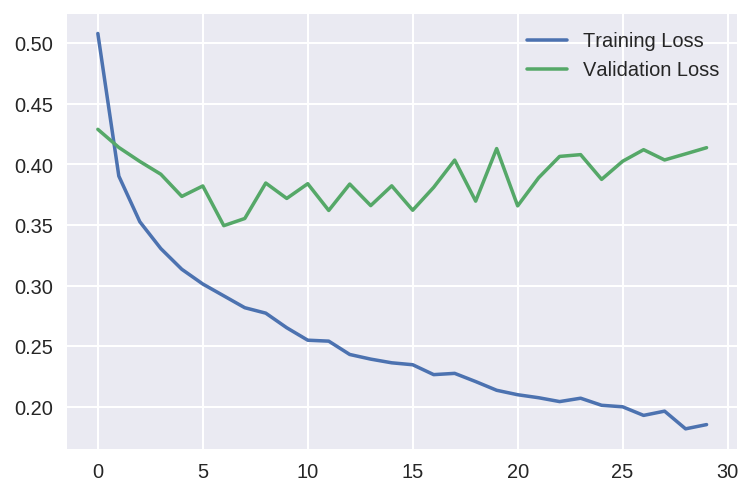

In [16]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon=False)

Network with Dropout

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784, 256)
    self.hidden2 = nn.Linear(256, 128)
    self.hidden3 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)
    
    #Droupout module with 0.2 drop probability
    self.dropout = nn.Dropout(p=0.22)
    
  def forward(self, x):
    #make sure input images i flattened
    x = x.view(x.shape[0], -1)
    
    #Now with droupout
    x = self.dropout(F.relu(self.hidden1(x)))
    x = self.dropout(F.relu(self.hidden2(x)))
    x = self.dropout(F.relu(self.hidden3(x)))
    
    #output so no dropout here
    x = F.log_softmax(self.output(x), dim=1)
    
    return x
   

In [23]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    
    optimizer.zero_grad()
    
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    model.train()
      
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
      
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss:  {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}". format(accuracy/len(testloader)))  
      

Epoch: 1/30..  Training Loss: 0.619..  Test Loss:  0.545..  Test Accuracy: 0.812
Epoch: 2/30..  Training Loss: 0.489..  Test Loss:  0.464..  Test Accuracy: 0.838
Epoch: 3/30..  Training Loss: 0.461..  Test Loss:  0.425..  Test Accuracy: 0.849
Epoch: 4/30..  Training Loss: 0.447..  Test Loss:  0.409..  Test Accuracy: 0.853
Epoch: 5/30..  Training Loss: 0.430..  Test Loss:  0.421..  Test Accuracy: 0.842
Epoch: 6/30..  Training Loss: 0.425..  Test Loss:  0.403..  Test Accuracy: 0.854
Epoch: 7/30..  Training Loss: 0.417..  Test Loss:  0.415..  Test Accuracy: 0.855
Epoch: 8/30..  Training Loss: 0.410..  Test Loss:  0.404..  Test Accuracy: 0.855
Epoch: 9/30..  Training Loss: 0.406..  Test Loss:  0.381..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.401..  Test Loss:  0.414..  Test Accuracy: 0.852
Epoch: 11/30..  Training Loss: 0.392..  Test Loss:  0.398..  Test Accuracy: 0.860
Epoch: 12/30..  Training Loss: 0.396..  Test Loss:  0.391..  Test Accuracy: 0.867
Epoch: 13/30..  Training 

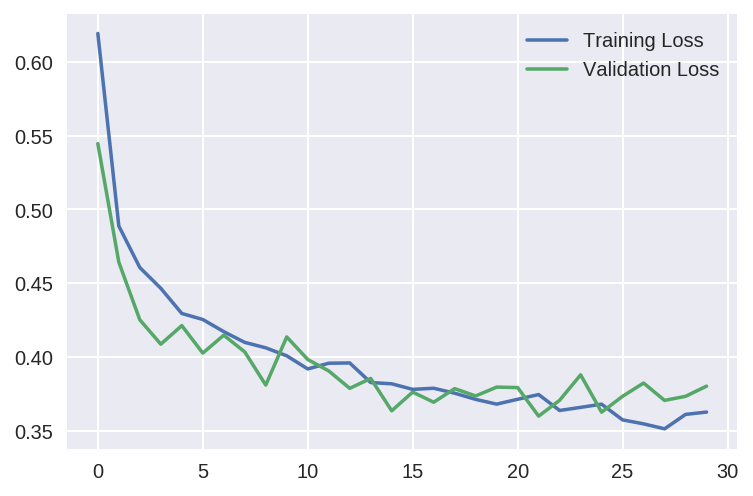

In [24]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.legend(frameon=False)

for more details visit this link

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%205%20-%20Inference%20and%20Validation%20(Solution).ipynb